# 위경도 추출

In [ ]:
import requests
header = {"Authorization" : "KakaoAK YourAPIKey"}
url = "https://dapi.kakao.com/v2/local/search/address.json?"

# 위도 추출
def get_address_x(address):
    params = {
        'query': address
    }
    x = ''

    try:
        response = requests.get(url, headers=header, params=params).json()
        x = response['documents'][0]['address']['x']

    except Exception as e:
        pass

    return x

# 경도 추출
def get_address_y(address):
    params = {
        'query': address
    }
    y = ''
    try:
        response = requests.get(url, headers=header, params=params).json()
        y = response['documents'][0]['address']['y']

    except Exception as e:
        pass

    return y

# 위경도 추출
import googlemaps
from tqdm import tqdm

mykey = 'Googlemap key'
maps = googlemaps.Client(key = mykey)

def trans_geo(addr):
    try:
        geo_location = maps.geocode(addr)[0].get('geometry')
        lat = geo_location['location']['lat']
        lng =  geo_location['location']['lng']
        return [lat,lng]
    except:
        return [0,0]

# 실행
for idx, addr in enumerate(tqdm(df_result_seoul.시설주소)):
    df_result_seoul.loc[idx,'latitude'] = trans_geo(addr)[0]
    df_result_seoul.loc[idx,'longitude'] = trans_geo(addr)[1]

# 동추출

In [ ]:
# 법정동
import requests

header = {"Authorization" : "KakaoAK YourAPIKey"}

def get_address_b(long, lat):
  url = "https://dapi.kakao.com/v2/local/geo/coord2regioncode.json?"
  h_name = ''
  params = {
    "x": long,
    "y": lat
  }
  try :
    h_name = requests.get(url, headers=header, params=params).json()['documents'][0]['region_3depth_name']
  except Exception as e:
    pass
  return h_name

df_result_seoul['법정동'] = df_result_seoul.apply(lambda row : get_address_b(row['longitude'], row['latitude']), axis = 1) # 9분

# 행정동
def get_address_h(long, lat):
  url = "https://dapi.kakao.com/v2/local/geo/coord2regioncode.json?"
  h_name = ''
  params = {
    "x": long,
    "y": lat
  }
  try :
    h_name = requests.get(url, headers=header, params=params).json()['documents'][1]['region_3depth_name']
  except Exception as e:
    pass
  return h_name

df_result_seoul['행정동'] = df_result_seoul.apply(lambda row : get_address_h(row['longitude'], row['latitude']), axis = 1)

# 지도 경로 실거리

In [ ]:
import requests

# API 키 설정
REST_API_KEY = "API Key"

# 요청 URL 설정
url = "https://apis-navi.kakaomobility.com/v1/directions"

def find_distance(origin_경도, origin_위도, dest_경도, dest_위도):
  params = {
    "origin": f"{origin_경도},{origin_위도}",
    "destination": f"{dest_경도},{dest_위도}",
    "waypoints": "",
    "priority": "RECOMMEND",
    "car_fuel": "GASOLINE",
    "car_hipass": "false",
    "alternatives": "false",
    "road_details": "false"
    }

# 요청 헤더 설정
  headers = {
      "Authorization": f"KakaoAK {REST_API_KEY}"
  }

# GET 요청 보내기
  response = requests.get(url, params=params, headers=headers)

  if response.status_code == 200:
    distance = response['routes'][0]['summary']['distance']
  else:
    pass
  return distance

params = {
  "origin": "129.0974,35.1309",
  "destination": "129.1012,35.133",
  "waypoints": "",
  "priority": "RECOMMEND",
  "car_fuel": "GASOLINE",
  "car_hipass": "false",
  "alternatives": "false",
  "road_details": "false"
  }

# 요청 헤더 설정
headers = {
    "Authorization": f"KakaoAK {REST_API_KEY}"
}

# GET 요청 보내기
response = requests.get(url, params=params, headers=headers)

import folium

# JSON 데이터
roads = response.json()['routes'][0]['sections'][0]['roads']

# 지도 생성
m = folium.Map(location=[roads[0]['vertexes'][1], roads[0]['vertexes'][0]], zoom_start=15)

# 선 추가
for road in roads:
    vertexes = [(road['vertexes'][i+1], road['vertexes'][i]) for i in range(0, len(road['vertexes']), 2)]
    folium.PolyLine(
        locations=vertexes,
        color='blue',
        weight=2.5,
        opacity=1
    ).add_to(m)

# 지도를 HTML 파일로 저장
m

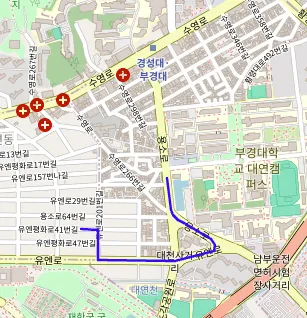

# 최단거리 산출

In [ ]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # 지구 반지름(m)

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)

    a = math.sin(dlat / 2) * math.sin(dlat / 2) + \
        math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * \
        math.sin(dlon / 2) * math.sin(dlon / 2)

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

# 최단 거리
min_distances = []

for i in range(len(df_grid)):
  grid_lat, grid_lon = df_grid['mid_y'][i], df_grid['mid_x'][i]
  min_distance = float('inf')

  for i in range(len(df)):
    store_lat, store_lon = df.loc[i,'위도'], df.loc[i,'경도']

    distance_meters = haversine_distance(grid_lat, grid_lon, store_lat, store_lon)
    min_distance = min(min_distance, distance_meters)

  min_distances.append(min_distance)

df_grid['dist_store'] = min_distances

# 로드뷰 바로가기

In [ ]:
import matplotlib.pyplot as plt

gdf_jinju.plot()
plt.show()

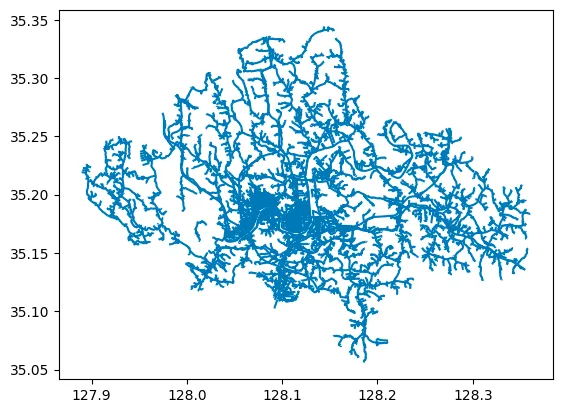

In [ ]:
import folium
# foilum 시각화
m = folium.Map(location=[35.1796, 128.1076], zoom_start=12)

for idx, row in gdf_jinju.iterrows():
    geom = row['geometry']

    if geom.geom_type == 'LineString':
        coords = [(coord[1], coord[0]) for coord in geom.coords]  # 좌표값 순서 변경
        folium.PolyLine(locations=coords, color='blue', weight=3).add_to(m)

m

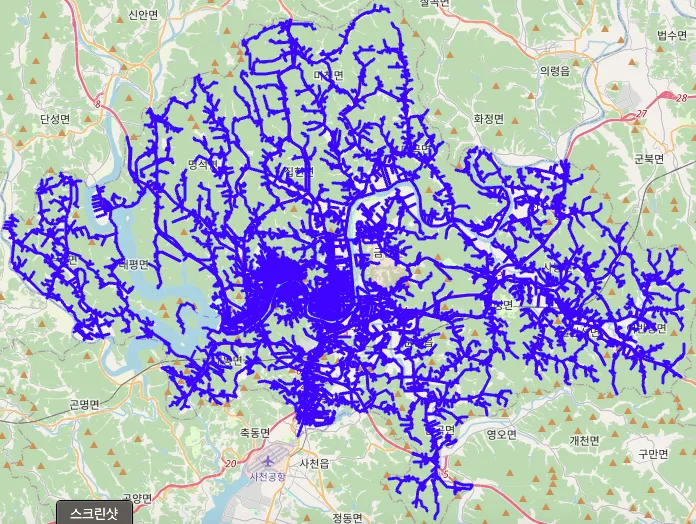

In [ ]:
def view_roadmap(index):
  geom = gdf_jinju['geometry'][index]
  coords = [(coord[1], coord[0]) for coord in geom.coords]

  # 중심 좌표
  total_latitude = 0
  total_longitude = 0

  for lat, lon in coords:
      total_latitude += lat
      total_longitude += lon

  average_latitude = total_latitude / len(coords)
  average_longitude = total_longitude / len(coords)

  m = folium.Map(location=[average_latitude, average_longitude], zoom_start=17)
  folium.PolyLine(locations=coords, color='blue', weight=10).add_to(m)
  m

  print(gdf_jinju['RN'][index])
  return m

print('도로명 라인 갯수 :',gdf_jinju.shape[0])
# 8634

view_roadmap(7000)
# 향교로120번길

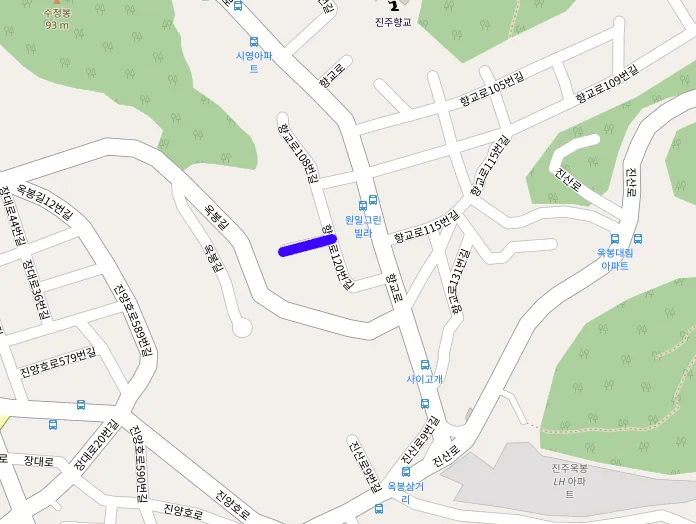

In [ ]:
geom = gdf_jinju['geometry'][1000]
coords = [(coord[1], coord[0]) for coord in geom.coords]

# 중심 좌표
total_latitude = 0
total_longitude = 0

for lat, lon in coords:
    total_latitude += lat
    total_longitude += lon

average_latitude = total_latitude / len(coords)
average_longitude = total_longitude / len(coords)
average_latitude, average_longitude
# (35.20133251770708, 128.08208205786178)

import requests
api_key = "API KEY"

def get_street_view_image_url(latitude, longitude, size="600x300", fov=90, pitch=0, key="YOUR_API_KEY"):
    base_url = "https://maps.googleapis.com/maps/api/streetview"
    params = {
        "size": size,
        "fov": fov,
        "pitch": pitch,
        "location": f"{latitude},{longitude}",
        "key": key
    }
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        return response.url
    else:
        return None

latitude = 35.1282  # 예시 위도 값
longitude = 129.0969  # 예시 경도 값


street_view_url = get_street_view_image_url(latitude, longitude, key=api_key)
print("Street View Image URL:", street_view_url)

# GOOGLE ROADVIEW 진주시 없음
geom = gdf_jinju['geometry'][7000]
coords = [(coord[1], coord[0]) for coord in geom.coords]

for i in range(len(coords)):
  latitude = coords[i][0]
  longitude = coords[i][1]

  roadview_url = f'https://map.kakao.com/link/roadview/{latitude},{longitude}'
  print(roadview_url)

https://map.kakao.com/link/roadview/35.19569540123273,128.09191402097449

https://map.kakao.com/link/roadview/35.19563984346498,128.09167511166322

https://map.kakao.com/link/roadview/35.19558631764593,128.09143079982832

https://map.kakao.com/link/roadview/35.19557754209367,128.09139524568198